In [ ]:
# Imports
import s3fs
import seaborn as sns
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
%matplotlib inline

from tensorflow.keras.layers import SimpleRNN,LSTM,Conv1D, MaxPooling2D, Flatten, Dropout
from time import time

In [ ]:

# User Settings
# num_lags    = 5 # Number of lags for RNN and LSTM
choose_lags    = [1,2,3,4,5] # choose lags for RNN and LSTM
num_exps   = 5 # Number of experiments for the box model
num_epochs = 5 # Number of Epocs
# models = ['DNN','RNN','LSTM']
models = ['LSTM']


# Defaults for DNN: num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001

# exp_neurons     = [5,50,100,200]
exp_neurons     = [100]
exp_layers      = [1,2,3]
exp_activation  = ["relu","tanh"]
exp_learnrate   = [0.001,0.01,0.1]

# Experiments (Indicate which hyperparameter to vary (varyname) and the corresponding values (varyvalues))
# The other parameters will be set to the "default" value in choose_hyperparams()
# varyname = 'activation'
# varyvalues = exp_activation
varyname = 'neurons'
varyvalues = exp_neurons

In [ ]:
# Model Code and Functions by Yiluan and Authors Above

# Data Preparation Functions
def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

# modified original code to loop by experiments
def prepare_data_new(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    
    # change expnumber to int for sorting
    if data['id'].dtype != 'int':
        data['id'] = data['id'].apply(lambda x: int(x[3:])) 
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    
    # get list of experiments
    exps = list(data['id'].unique())
    
    # Make empty list to store the data by experiment
    x_data_list=[None]*len(exps)
    y_data_list=[None]*len(exps)
    
    # Store experiments in loop, by experiment
    for exp in range(len(exps)): # added loop
        data_subset=data[data['id']==exps[exp]]
        x_data_list[exp] = data_subset[input_columns].iloc[:-1, :]
        y_data_list[exp] = data_subset[output_columns].iloc[1:, :]
    
    # Concatenate data together
    x_data = pd.concat(x_data_list)
    y_data = pd.concat(y_data_list)
    return x_data, y_data

# prepare time series data for RNN
def prepare_data_ts(data, input_columns, output_columns, lags=[1]):
    """ Splits data to input/output with corresponding lag """
    # if data['id'].dtype == 'int':
    if data['id'].dtype != 'int': # corrected bug
        data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    exps = list(data['id'].unique())
    
    # Preallocate, with lag dimension in x_data
    x_data=np.empty(shape=(0,len(lags),len(input_columns)),dtype='float64') 
    y_data=np.empty(shape=(0,len(output_columns)),dtype='float64') 
    
    # Loop by experiment
    for exp in range(len(exps)):
      
        # Get subset for each ex
        data_subset=data[data['id']==exps[exp]]
        
        # Preallocate
        x_data_subset=np.empty(shape=((data_subset.shape[0]-max(lags)),len(lags),len(input_columns)),dtype='float64') 
        y_data_subset=np.empty(shape=((data_subset.shape[0]-max(lags)),len(output_columns)),dtype='float64') 
        
        # Assign y_data and concatenate to end
        y_data_subset[:,:] = data_subset[output_columns].iloc[max(lags):, :]
        y_data = np.concatenate([y_data,y_data_subset])
        
        # Apply lags to x_data
        for i in range(len(lags)):
          lags.sort(reverse=True)
          lag=lags[i]
          x_data_subset[:,i,:] = data_subset[input_columns].iloc[(max(lags)-lag):(data_subset.shape[0]-lag), :]
        x_data = np.concatenate([x_data,x_data_subset])

    return x_data, y_data


# Box Emulator Model Code (for time series data)
def get_starting_conds_ts(data, input_vars, exp, lags=[1], starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:(starting_ts+max(lags)), :]

    return ts_data

def box_emulator_ts(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps, lags):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    scaled_input = np.expand_dims(scaled_input, axis=0)
    static_input = scaled_input[:,:,-6:]

    # select specfic lags
    lags.sort(reverse=True)
    ind=[]
    for i in range(len(lags)):
      ind.append(max(lags)-lags[i])

    for i in range(num_timesteps):

        if i == 0:
            pred = mod.predict(scaled_input[:,ind,:])
            dynamic_input = np.concatenate([scaled_input[:,1:,0:3],np.expand_dims(pred, axis=0)], axis=1)
            new_input = np.concatenate([dynamic_input,static_input], axis=2)
            pred_array = pred

        else:
            pred = mod.predict(new_input[:,ind,:])
            dynamic_input = np.concatenate([new_input[:,1:,0:3],np.expand_dims(pred, axis=0)], axis=1)
            new_input = np.concatenate([dynamic_input,static_input], axis=2)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results

def run_emulator_ensemble_ts(input_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1440, lags=[1]):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_expiriments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    run_length=run_length-max(lags)
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[max(lags):,:]).reset_index(drop=True)  
    
    for i in range(num_expiriments):
        
        init_conds = get_starting_conds_ts(input_data, input_vars, exps[i],lags)
        preds = box_emulator_ts(mod, init_conds, input_scaler, output_scaler, run_length, lags)
        # preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df


# Neural Network Model Builders
def rec_neural_net(lags=[1], num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3, option=["RNN","LSTM","DNN"]):
    """ Build and return recurrent neural network with specified hyperparameters"""
    
    # Use lags for LSTM and RNN
    if option == "DNN":
        input_layer = Input(num_input_columns)
    else:
        input_layer = Input(shape=[len(lags),num_input_columns])
    n_net = input_layer
    
    # Build models
    if option == "RNN":
        for l in range(num_layers):
            n_net= SimpleRNN(num_neurons, activation=activation, return_sequences=True)(n_net)
            # n_net=Dropout(0.5)(n_net)
        out = SimpleRNN(num_output_columns)(n_net)
    elif option == "LSTM":
        for l in range(num_layers):
            n_net= LSTM(num_neurons, activation=activation, return_sequences=True)(n_net)
            # n_net=Dropout(0.5)(n_net)
        out = LSTM(num_output_columns)(n_net)
    elif option == "DNN":
        for l in range(num_layers):
            n_net= Dense(num_neurons, activation=activation)(n_net)
            # n_net=Dropout(0.5)(n_net)
        out = Dense(num_output_columns)(n_net)
    # elif option == "CNN":
    #   for l in range(num_layers):
    #     n_net = Conv1D(num_neurons, 3, activation=activation,padding="SAME")(n_net)
    #     # n_net = MaxPooling2D((2,2), padding="SAME")(n_net)
    #   out = Conv1D(num_output_columns, 3,padding="SAME")(n_net)
    # out = Flatten()(out)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    
    return mod

# Non TS versions for the models
def box_emulator(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results

def run_emulator_ensemble(input_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_expiriments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[1:,:]).reset_index(drop=True)  
    
    for i in range(num_expiriments):
        
        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df

def get_starting_conds(data, input_vars, exp, starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:starting_ts+1, :]

    return ts_data

def choose_hyperparams(varyname,varyvalues):
    # Defaults for DNN: num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001
    num_layers  = 2
    num_neurons = 100
    activation  = "relu"
    learning_rate = 0.001
    
    # number of times to vary
    numvary = len(varyvalues)
    
    
    # Default settings Copy everything that number of times
    list_layers       = np.ones(numvary)*num_layers
    list_neurons      = np.ones(numvary)*num_neurons
    list_activation   = np.repeat(activation,numvary)
    list_learningrate = np.ones(numvary)*learning_rate
    exec("list_%s = np.copy(%s)" %(varyname,varyvalues))
    
    return list_layers,list_neurons,list_activation,list_learningrate

# -----------------------------------------------
""" Evaluation """

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def evaluate_mod(true_output, model_results):
    
    print('RMSE: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        rmse(true_output.iloc[:,0], model_results.iloc[:,0]),
        rmse(true_output.iloc[:,1], model_results.iloc[:,1]),
        rmse(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('R2: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        r2_corr(true_output.iloc[:,0], model_results.iloc[:,0]),
        r2_corr(true_output.iloc[:,1], model_results.iloc[:,1]),
        r2_corr(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('Hellenger Distance: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        hellinger_distance(true_output.iloc[:,0], model_results.iloc[:,0]),
        hellinger_distance(true_output.iloc[:,1], model_results.iloc[:,1]),
        hellinger_distance(true_output.iloc[:,2], model_results.iloc[:,2])))
    
    return

In [ ]:
# Script start and data preparation

seed = 8886
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# load data
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

# Confirm that data has loaded
test.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
28800,1.000000,0.069675,0.000000,0.000000,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155
28801,301.207794,0.068014,0.002547,0.000003,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155
28802,601.415588,0.066392,0.005037,0.000010,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155
28803,901.623352,0.064809,0.007463,0.000019,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155
28804,1201.831177,0.063264,0.009827,0.000030,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155


In [ ]:
# preprocess data
start = time()

input_vars, output_vars = train.columns[1:-1], train.columns[[1,2,3]]
# here I use the same scaler for input and output
scaler = MinMaxScaler()
scaled_train_array = scaler.fit_transform(train.iloc[:,1:-1])
scaled_val_array   = scaler.transform(val.iloc[:,1:-1])
# in the two steps below, attributes of the scaler are directly transferred to the scaler for the output
scaler_out = MinMaxScaler()
scaler_out.min_, scaler_out.scale_= scaler.min_[0:3],scaler.scale_[0:3]

# add the time and id variables that were not transformed to the dataframes
scaled_train=train.copy()
scaled_train[input_vars]=scaled_train_array
scaled_val=val.copy()
scaled_val[input_vars]=scaled_val_array

# Prepare time series data
scaled_train_in_ts, scaled_train_out_ts = prepare_data_ts(scaled_train, input_vars, output_vars, lags=choose_lags)
scaled_val_in_ts, scaled_val_out_ts = prepare_data_ts(scaled_val, input_vars, output_vars, lags=choose_lags)
# scaled_val_in[:,:,0:1] # checking

# Prepare data for DNN (no lag applied)
scaled_train_in, scaled_train_out = prepare_data_new(scaled_train, input_vars, output_vars)
scaled_val_in, scaled_val_out = prepare_data_new(scaled_val, input_vars, output_vars)

print("Preprocessed data in %f!"%(time()-start))

Preprocessed data in 185.017510!


In [ ]:
# Set values hyperparameter on experiment
list_layers,list_neurons,list_activation,list_learningrate = choose_hyperparams(varyname,varyvalues)

# Create dictionary for experiment results
exp_results = {}


# Giant loop to run for all experiments and models. it takes 30 min for 1 experiment, and 2 Epochs per model so might not be the most efficient...
for e in range(len(varyvalues)):
    starte = time()
    
    # Get corresponding hyperparameters
    num_layers = int(list_layers[e])
    num_neurons = int(list_neurons[e])
    activation = list_activation[e]
    learning_rate = list_learningrate[e]
    
    
    allmodels = {}
    history   = {}
    pred_nn   = {}
    true_val  = {}
    pred_box  = {}
    true_box  = {}
    
    for model in models:
        start = time()
        # Define Model
        tf.random.set_seed(seed)
        allmodels[model] = rec_neural_net(lags=choose_lags,num_layers=num_layers, num_neurons=num_neurons,activation=activation,learning_rate=learning_rate,
            num_input_columns=9, num_output_columns=3, option=model)
        
        # Train model
        if model == "DNN":
            history[model] = allmodels[model].fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                batch_size=256, epochs=num_epochs, verbose=1)
            
            pred_nn[model]  = pd.DataFrame(scaler_out.inverse_transform(allmodels[model].predict(scaled_val_in)))
            true_val[model] = pd.DataFrame(scaler_out.inverse_transform(scaled_val_out))          
            
            # Run Box Model
            random.seed(seed)       
            pred_box[model], true_box[model] = run_emulator_ensemble(val, allmodels[model], num_exps, input_vars, scaler, scaler_out)
    
        else:
            history[model] = allmodels[model].fit(scaled_train_in_ts, scaled_train_out_ts, validation_data=(scaled_val_in_ts, scaled_val_out_ts), 
                batch_size=256, epochs=num_epochs, verbose=1)
            
            pred_nn[model]  = pd.DataFrame(scaler_out.inverse_transform(allmodels[model].predict(scaled_val_in_ts)))
            true_val[model] = pd.DataFrame(scaler_out.inverse_transform(scaled_val_out_ts))
            
            # Run Box Model
            random.seed(seed)       
            pred_box[model], true_box[model] = run_emulator_ensemble_ts(val, allmodels[model], num_exps, input_vars, scaler, scaler_out, run_length=1440, lags=choose_lags)
    
        
        print("\tFinished calculations for %s in %f!" % (model,time()-start))
    
    # Store values by experiment
    exp_results[e] = [allmodels.copy(),history.copy(),pred_nn.copy(),true_val.copy(),pred_box.copy(),true_box.copy()]
    
    print("\tFinished experiment %i in %f!" % (e,time()-starte))

Epoch 1/5
7848/7848 [==============================] - 376s 48ms/step - loss: 3.3162e-04 - val_loss: 2.6293e-06
Epoch 2/5
7848/7848 [==============================] - 377s 48ms/step - loss: 3.1661e-06 - val_loss: 1.8889e-06
Epoch 3/5
7848/7848 [==============================] - 378s 48ms/step - loss: 2.3072e-06 - val_loss: 2.7318e-06
Epoch 4/5
7848/7848 [==============================] - 376s 48ms/step - loss: 1.8513e-06 - val_loss: 2.1639e-06
Epoch 5/5
7848/7848 [==============================] - 389s 50ms/step - loss: 1.5643e-06 - val_loss: 6.4071e-07
	Finished calculations for LSTM in 2121.882676!
	Finished experiment 0 in 2121.883030!


In [ ]:
#unpack dictionary and save relevant results (pred_box and true_box)

pred_box_all = {}
true_box_all = {}
for e in range(len(varyvalues)):
    pred_box_all[e] = exp_results[e][4]
    true_box_all[e] = exp_results[e][5]
    
np.save("Experiment_%s_Epoch%i_pred.npy"% (varyname,num_epochs),pred_box_all)
np.save("Experiment_%s_Epoch%i_true.npy"% (varyname,num_epochs),true_box_all)

In [ ]:
pred_box_all = np.load("Experiment_%s_Epoch%i_pred.npy"% (varyname,num_epochs),allow_pickle=True)[()]
true_box_all = np.load("Experiment_%s_Epoch%i_true.npy"% (varyname,num_epochs),allow_pickle=True)[()]

# evaluation
for e in range(len(varyvalues)):
  for model in models:
    print("Metrics for Box Emulator %s: %s = "%(model,varyname)+str(varyvalues[e]))
    evaluate_mod(true_box_all[e][model], pred_box_all[e][model])

Metrics for Box Emulator LSTM: neurons = 100
RMSE: Precursor: 0.00049, Gas: 0.00574, Aerosols: 0.00873
R2: Precursor: 0.99822, Gas: 0.96352, Aerosols: 0.89409
Hellenger Distance: Precursor: 0.00032, Gas: 0.06030, Aerosols: 0.27265


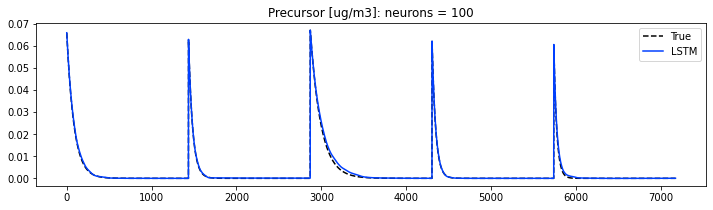

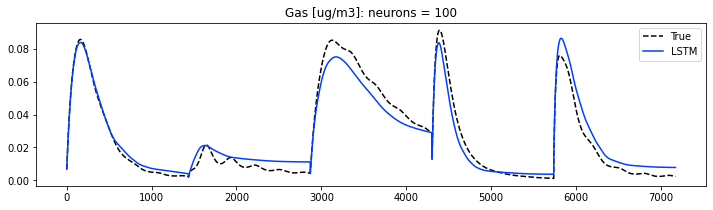

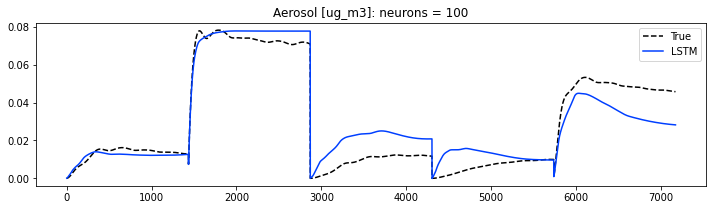

In [ ]:
# Time to visualize...

#Separate figure for each variable
for i in range(0,len(output_vars)):
    
    # Split plots by variable to compare
    fig,axs = plt.subplots(len(varyvalues),1,figsize=(12,3))
    plt.style.use('seaborn-bright')
    
    lab = output_vars[i]
    
    
    
    # Plot 1 experiment for each subplot
    for e in range(len(varyvalues)):
    
        plt.subplot(len(varyvalues),1,e+1)
        
        # Plot 2 true values
        # plt.plot(true_box_all[e]["DNN"].iloc[:,i],label="True",color='k',linestyle=":")
        plt.plot(true_box_all[e]["LSTM"].iloc[:,i],label="True",color='k',linestyle="--")
        
        # Plot each model prediction
        for model in models:
            plt.plot(pred_box_all[e][model].iloc[:,i],label=model)
        plt.title("%s: %s = "%(lab,varyname)+str(varyvalues[e]))
        plt.legend()
# plt.tight_layout()


